# Inter-channel interference (ICI) estimation using constellation diagrams Gaussian Mixture Models in a 32 GBd system.

## Initialization

### Libraries

In [1]:
import json
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sofa
import tensorflow.keras as ker
from joblib import dump, load
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, models, regularizers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

2024-02-07 17:16:46.273492: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 17:16:46.314637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 17:16:46.314700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 17:16:46.315731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 17:16:46.322166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 17:16:46.323720: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Globals

In [2]:
# Special function to read the known data structure
def read_data(folder_rx):
    data = defaultdict(
        defaultdict(
            defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy).copy
        ).copy
    )
    for dist_pow in os.listdir(folder_rx):
        if not os.path.isdir(os.path.join(folder_rx, dist_pow)):
            continue
        print(f"reading {dist_pow}")
        for spac in os.listdir(os.path.join(folder_rx, dist_pow)):
            print(f"reading {dist_pow}/{spac}")
            consts = os.listdir(os.path.join(folder_rx, dist_pow, spac))
            for const in consts:
                if const.endswith("xlsx"):
                    continue
                song, orth, osnr, spacing, distance, power = const.split("_")
                # Remove extension
                power = power.split(".")[0]
                spacing = spacing.replace("p", ".")
                osnr = osnr.replace("p", ".")
                mat = sp.io.loadmat(os.path.join(folder_rx, dist_pow, spac, const))
                data[distance][power][spacing][osnr][song][orth] = mat["rconst"][0]
    return data


def split(a, n):
    k, m = divmod(len(a), n)
    return np.array(
        [a[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n)]
    )

In [3]:
def calc_once(varname, fn, args):
    """Calculate a variable only once."""
    if varname not in globals() or eval(varname) is None:
        return fn(**args)
    return eval(varname)


def estimation_model(
    layers_props_lst: list, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """Compile a sequential model for regression purposes."""
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def estimation_crossvalidation(
    X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
):
    """Crossvalidation of an estimation network."""
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": [], "prod": []}
    scores["r2"] = {"train": [], "test": [], "prod": []}
    scores["rmse"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = estimation_model(layer_props, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train,
                y_train,
                epochs=5000,
                batch_size=64,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        predictions_train = model.predict(X_train, verbose=0)
        # Predict using test values
        predictions_test = model.predict(X_test_kf, verbose=0)
        # Predict using production values
        predictions_prod = model.predict(X_prod_kf, verbose=0)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": [y_prod], "Predicted ICI": [predictions_prod]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        mae_score_prod = mean_absolute_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        r2_score_prod = r2_score(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )

        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"], squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"], squared=False
        )
        rmse_score_prod = mean_squared_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"], squared=False
        )

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["mae"]["prod"].append(mae_score_prod)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["r2"]["prod"].append(r2_score_prod)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        scores["rmse"]["prod"].append(rmse_score_prod)

    return scores


def test_estimation_model(
    data,
    data_prod,
    n_splits,
    max_neurons,
    activations,
    use_osnr=True,
    loss_fn="mean_absolute_error",
):
    """Test a spectral spacing estimation model with given parameters."""
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''}")
    callbacks = [
        EarlyStopping(
            monitor="loss", patience=30, mode="min", restore_best_weights=True
        )
    ]

    return estimation_crossvalidation(
        X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
    )

In [4]:
def plot_constellation_diagram(X, ax):
    ax.scatter(X.real, X.imag, alpha=0.5)
    ax.set_title("Constellation diagram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")


def calculate_gmm(data, gm_kwargs):
    return GaussianMixture(**gm_kwargs).fit(data)


def calculate_1d_histogram(X, bins):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]

    return hist_x, hist_y


def plot_1d_histogram(X, bins=128, ax=None):
    ax.hist(X, bins=bins, density=True, alpha=0.5, label="Calculated histogram")


def plot_gmm_1d(gm, limits, ax):
    x = np.linspace(*limits, 1000)

    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.plot(x, pdf_individual, "--", label="Adjusted histogram")


def plot_gmm_2d(gm, limits, ax):
    x = y = np.linspace(*limits)
    X, Y = np.meshgrid(x, y)
    Z = -gm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    ax.contour(
        X,
        Y,
        Z,
        norm=LogNorm(vmin=1.0, vmax=1000.0),
        levels=np.logspace(0, 3, 25),
        cmap="seismic",
    )


def calculate_3d_histogram(X, bins, limits):
    hist, xedges, yedges = np.histogram2d(
        X.real, X.imag, bins=bins, range=[[*limits], [*limits]]
    )
    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    return hist, x_mesh, y_mesh


def plot_3d_histogram(x_mesh, y_mesh, hist, ax):
    ax.plot_surface(
        x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none"
    )
    ax.set_title("3D Histogram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")


def plot_results(x_values, scores, xlabel, log=False, intx=False):
    plt.figure(figsize=(8, 6), layout="constrained")
    plt.scatter(x_values, scores)
    plt.plot(x_values, scores)
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    if log:
        plt.xscale("log", base=2)
    if intx:
        plt.xticks(x_values)
    plt.grid(True)
    plt.show()


def joblib_load(file):
    try:
        return load(file)
    except FileNotFoundError:
        print(f"[ERROR]: File {file} not found")
        return None


def joblib_save(var, file):
    dump(var, file)

### Load data

In [5]:
folder_rx = "../../../Databases/32GBd/ICI characterization/"

# Read received data
data = read_data(folder_rx)

# Try to load histograms
file_models_hist = "./models32_hist.pkl"
file_models_gmm = "./models32_gmm.pkl"

models_hist = joblib_load(file_models_hist)
models_gmm = joblib_load(file_models_gmm)
models_tuple = (
    None
    if models_hist is None or models_gmm is None
    else (models_hist, models_gmm)
)

reading 0km_0dBm
reading 0km_0dBm/37p5GHz
reading 0km_0dBm/36GHz
reading 0km_0dBm/34GHz
reading 0km_0dBm/50GHz
reading 0km_0dBm/33p5GHz
reading 0km_0dBm/29p5GHz
reading 0km_0dBm/29GHz
reading 0km_0dBm/32p5GHz
reading 0km_0dBm/35p5GHz
reading 0km_0dBm/31p5GHz
reading 0km_0dBm/30p5GHz
reading 0km_0dBm/33GHz
reading 0km_0dBm/35GHz
reading 0km_0dBm/32GHz
reading 0km_0dBm/34p5GHz
reading 0km_0dBm/30GHz
reading 0km_0dBm/31GHz
reading 0km_0dBm/28p5GHz
reading 270km_0dBm
reading 270km_0dBm/37p5GHz
reading 270km_0dBm/36GHz
reading 270km_0dBm/34GHz
reading 270km_0dBm/50GHz
reading 270km_0dBm/33p5GHz
reading 270km_0dBm/29p5GHz
reading 270km_0dBm/32p5GHz
reading 270km_0dBm/35p5GHz
reading 270km_0dBm/31p5GHz
reading 270km_0dBm/30p5GHz
reading 270km_0dBm/33GHz
reading 270km_0dBm/35GHz
reading 270km_0dBm/32GHz
reading 270km_0dBm/34p5GHz
reading 270km_0dBm/30GHz
reading 270km_0dBm/31GHz
reading 270km_9dBm
reading 270km_9dBm/37p5GHz
reading 270km_9dBm/36GHz
reading 270km_9dBm/34GHz
reading 270km_9dBm/5

## Calculate histograms

In [6]:
def get_histograms(data):
    histograms_hist = defaultdict(
        defaultdict(
            defaultdict(defaultdict(defaultdict(defaultdict(list).copy).copy).copy).copy
        ).copy
    )
    histograms_gmm = defaultdict(
        defaultdict(
            defaultdict(defaultdict(defaultdict(defaultdict(list).copy).copy).copy).copy
        ).copy
    )
    bins = 128
    limits = [-5, 5]

    for distance in data.keys():
        for power in data[distance].keys():
            for spacing in data[distance][power].keys():
                for osnr in data[distance][power][spacing].keys():
                    for song in data[distance][power][spacing][osnr].keys():
                        for orth in data[distance][power][spacing][osnr][song].keys():
                            print(f"Calculating GMM for {distance}/{power}/{spacing}/{osnr}/{song}/{orth}")
                            X_rx = data[distance][power][spacing][osnr][song][orth]
                            X_chs = split(X_rx, 3)

                            for n, x_ch in enumerate(X_chs):
                                # Calculate 2D GMM
                                input_data = np.vstack((x_ch.real, x_ch.imag)).T
                                gm_kwargs = {
                                    "means_init": np.array(
                                        list(product([-3, -1, 1, 3], repeat=2))
                                    ),
                                    "n_components": 16,
                                }
                                gm_2d = calculate_gmm(input_data, gm_kwargs)
    
                                # Calculate 3D histogram
                                hist, x_mesh, y_mesh = calculate_3d_histogram(x_ch, bins, limits)
    
                                # Save 3D histogram
                                histograms_hist[distance][power][spacing][osnr][song][orth].append(hist)
    
                                # Calculate I and Q histograms
                                hist_x, hist_y = calculate_1d_histogram(x_ch.real, bins)
                                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                                gm_kwargs = {
                                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
                                    "n_components": 4,
                                }
                                gm_i = calculate_gmm(input_data, gm_kwargs)
    
                                # Q
                                hist_x, hist_y = calculate_1d_histogram(x_ch.imag, bins)
                                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                                gm_kwargs = {
                                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
                                    "n_components": 4,
                                }
                                gm_q = calculate_gmm(input_data, gm_kwargs)
    
                                # Save gaussians
                                histograms_gmm[distance][power][spacing][osnr][song][orth].append([gm_2d, gm_i, gm_q])

    histograms_hist = dict(histograms_hist)
    histograms_gmm = dict(histograms_gmm)
    return histograms_hist, histograms_gmm

models_tuple = calc_once("models_tuple", get_histograms, {"data": data})
models_hist, models_gmm = models_tuple
joblib_save(models_hist, file_models_hist)
joblib_save(models_gmm, file_models_gmm)

In [7]:
data["0km"]["0dBm"]["37.5GHz"]["23.04dB"]["Song4"]["Y"].shape

(39531,)

In [8]:
def plot_histograms(data, histograms_gmm, distance, power, spacing, osnr, song, orth):
    def plot(data, histograms_gmm, distance, power, spacing, osnr, song, orth):
        # Extract data
        X_ch = data[distance][power][spacing][osnr][song][orth]

        plt.figure(figsize=(12, 12), layout="tight")

        # Plot constellation diagram
        ax = plt.subplot(2, 2, 1)
        plot_constellation_diagram(X_ch, ax)

        gm_2d = histograms_gmm[distance][power][spacing][osnr][song][orth][0][0]

        # Plot 2D GMM
        plot_gmm_2d(gm_2d, limits, ax)
        ax.grid(True)

        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits)

        # Plot 3D histogram
        ax = plt.subplot(2, 2, 2, projection="3d")
        plot_3d_histogram(x_mesh, y_mesh, hist, ax)

        # Plot I and Q histograms separately
        # I
        ax = plt.subplot(2, 2, 3)
        plot_1d_histogram(X_ch.real, bins=bins, ax=ax)

        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
            "n_components": 4,
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_i, limits, ax)

        ax.set_title("I-Histogram")
        ax.set_xlabel("I")
        ax.grid(True)

        # Q
        ax = plt.subplot(2, 2, 4)
        plot_1d_histogram(X_ch.imag, bins=bins, ax=ax)

        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1),
            "n_components": 4,
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_q, limits, ax)
        ax.set_title("Q-Histogram")
        ax.set_xlabel("Q")
        ax.grid(True)

        plt.suptitle(f"Plots for constellation at {distance} with {power} launch power, {spacing} spectral spacing, {osnr} OSNR, Song {song[-1]}, {orth} component.")

        plt.show()

    bins = 128
    limits = [-5, 5]

    plot(data, histograms_gmm, distance, power, spacing, osnr, song, orth)

def plot_menu(data):
    def select_menu(data, name):
        print(f"Select {name}")
        options = {n:option for n, option in enumerate(data.keys())}
        for n in options.keys():
            print(f"[{n}]: {options[n]}")
        choice = None
        while choice is None:
            choice = options.get(int(input()))
            if choice is None:
                print("Invalid input, try again")
        print(f"Selected {choice}")
        return choice
            
                
    # Distance
    distance = select_menu(data, "distance")
    
    # Power
    power = select_menu(data[distance], "launch power")
    
    # Spacing
    spacing = select_menu(data[distance][power], "spacing")

    # OSNR
    osnr = select_menu(data[distance][power][spacing], "OSNR")
    
    # Song
    song = select_menu(data[distance][power][spacing][osnr], "song")
    
    # Component
    orth = select_menu(data[distance][power][spacing][osnr][song], "component")

    plot_histograms(data, models_gmm, distance, power, spacing, osnr, song, orth)

### Plot constellation diagrams, contour for GMM and histograms

Select distance
[0]: 0km
[1]: 270km


 0


Selected 0km
Select launch power
[0]: 0dBm


 0


Selected 0dBm
Select spacing
[0]: 37.5GHz
[1]: 36GHz
[2]: 34GHz
[3]: 50GHz
[4]: 33.5GHz
[5]: 29.5GHz
[6]: 29GHz
[7]: 32.5GHz
[8]: 35.5GHz
[9]: 31.5GHz
[10]: 30.5GHz
[11]: 33GHz
[12]: 35GHz
[13]: 32GHz
[14]: 34.5GHz
[15]: 30GHz
[16]: 31GHz
[17]: 28.5GHz


 0


Selected 37.5GHz
Select OSNR
[0]: 23.04dB
[1]: 18dB
[2]: 28.06dB
[3]: 15.93dB
[4]: 27.16dB
[5]: 21.09dB
[6]: 25.18dB
[7]: 30.03dB
[8]: 26.08dB
[9]: 22.02dB
[10]: 29.09dB
[11]: 20.2dB
[12]: 24.08dB
[13]: 18.99dB
[14]: 16.9dB


 0


Selected 23.04dB
Select song
[0]: Song4
[1]: Song3
[2]: Song2
[3]: Song1


 0


Selected Song4
Select component
[0]: Y


 0


Selected Y


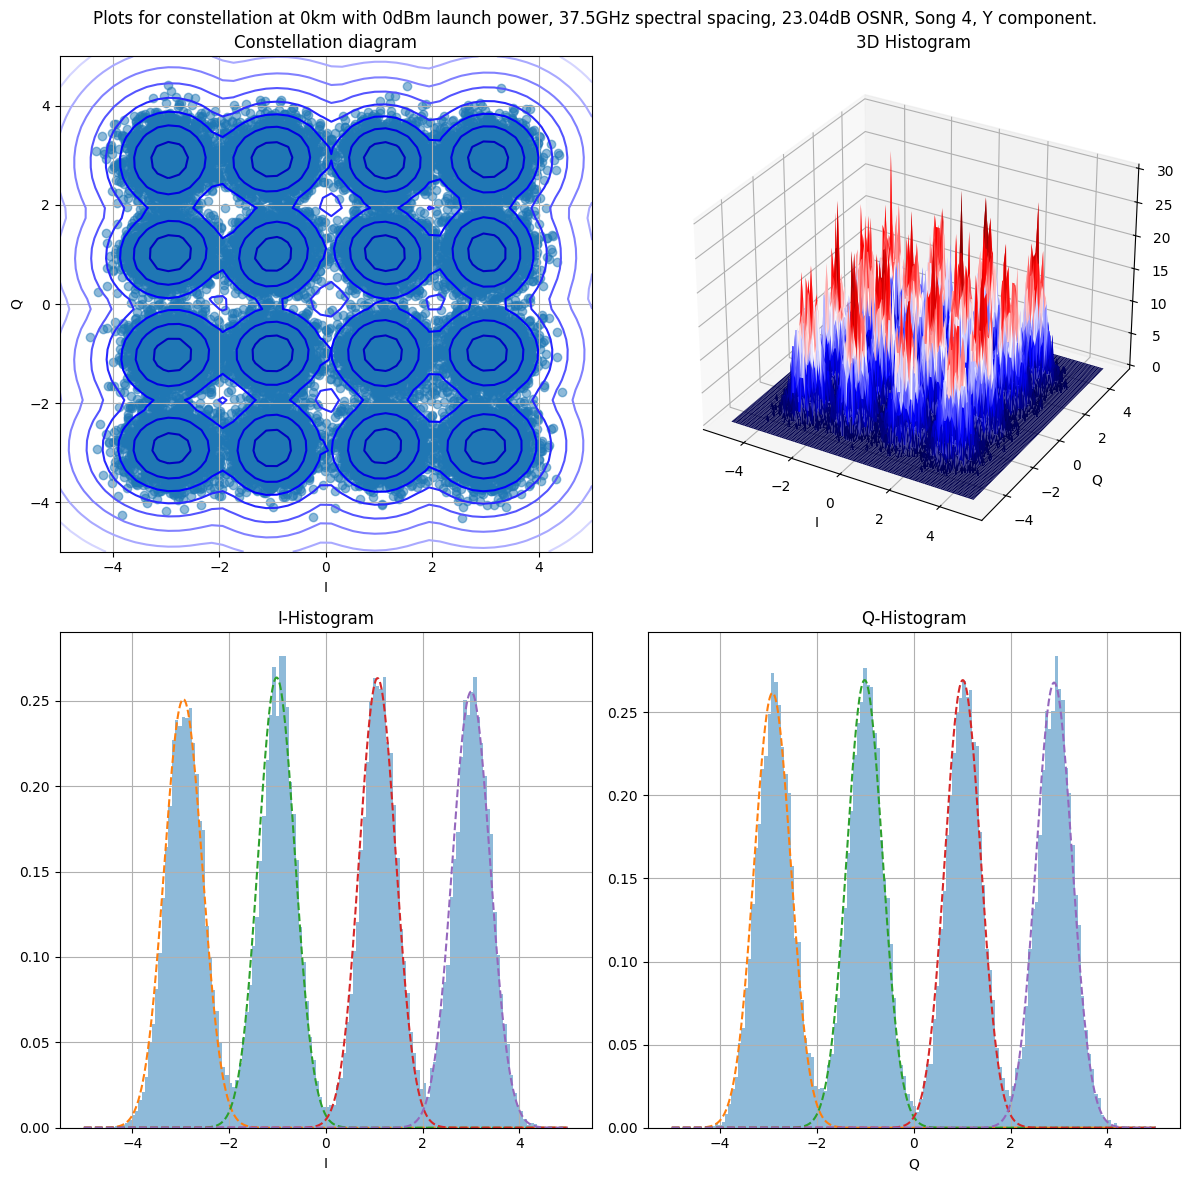

In [9]:
plot_menu(data)

## Pre-process data

In [10]:
# Dataframe with 98 columns
# First 32 for means
# Following 64 for each value of the covariances matrixes
# (repeated values are included)
# Next to last for OSNR value in dB
# Last column for spectral spacing value in GHz

n_features = 82
df_dict = {f"col{n}": [] for n in range(n_features)}
data_list = []

# Iterate over the dictionary and populate the DataFrame
for distance in models_gmm.keys():
    for power in models_gmm[distance].keys():
        for spacing in models_gmm[distance][power].keys():
            for osnr in models_gmm[distance][power][spacing].keys():
                for song in models_gmm[distance][power][spacing][osnr].keys():
                    for orth in models_gmm[distance][power][spacing][osnr][song].keys():
                        for n in range(3):
                            gmm_2d = models_gmm[distance][power][spacing][osnr][song][orth][n][0]
                            means = gmm_2d.means_.flatten()
                            covariances_raw = gmm_2d.covariances_.flatten()
                            # Remove repeated covariances
                            covariances = []
                            for x, covariance in enumerate(covariances_raw):
                                if x % 4 != 1:
                                    covariances.append(covariance)
                            osnr_value = np.array([float(osnr[:-2])])
                            spacing_value = np.array([float(spacing[:-3])])
                
                            features = np.concatenate((means, covariances, osnr_value, spacing_value))
                            row_dict = {f"col{n}": feature for n, feature in enumerate(features)}
                            data_list.append(row_dict)

# Convert the list of dictionaries into a DataFrame
df = pl.DataFrame(data_list)

# Print the DataFrame
df.write_json("gmm32_features.json")

In [11]:
# Show the original dataframe
df

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,…,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.906748,-2.911143,-2.884753,-1.026353,-2.926178,1.029001,-2.938117,2.914156,-1.004189,-2.914388,-0.99787,-0.993893,-0.981621,1.005873,-1.014376,2.924727,1.075244,-2.870482,1.077146,-0.988253,1.111333,1.029008,1.105264,2.906392,2.988362,-2.874957,3.023599,-0.986034,3.019907,1.04221,3.045697,2.925743,0.175245,-0.001096,0.131946,0.160702,0.010529,…,0.005496,0.152102,0.142053,0.003829,0.128588,0.141778,0.015266,0.145246,0.169615,0.009658,0.141329,0.149127,0.010769,0.147429,0.145779,-0.000499,0.145867,0.138065,-0.00844,0.126383,0.141429,-0.005463,0.130423,0.160773,0.003286,0.139385,0.158456,-0.000616,0.142523,0.133021,-0.006206,0.157686,0.151988,-0.000654,0.143484,23.04,37.5
-2.890607,-2.914782,-2.901788,-0.971464,-2.909128,1.050183,-2.928704,2.940112,-0.963436,-2.871445,-0.972538,-0.978922,-0.962094,1.06589,-0.959223,2.963118,1.100257,-2.847411,1.11284,-0.978568,1.118047,1.058782,1.107609,2.929226,3.044364,-2.856313,3.065766,-0.972282,3.047531,1.061961,3.053718,2.949538,0.170754,0.00411,0.153396,0.151196,0.002554,…,0.002712,0.129376,0.145377,-0.005976,0.140807,0.132705,0.013626,0.134375,0.135994,0.004713,0.134618,0.145339,-0.000648,0.142266,0.141284,0.003172,0.130859,0.134963,0.001733,0.122138,0.14809,0.007417,0.143744,0.163837,-0.002522,0.161362,0.15084,0.002232,0.144909,0.161692,0.003871,0.150434,0.152402,-0.004879,0.136987,23.04,37.5
-2.901374,-2.903524,-2.900451,-0.986049,-2.916037,1.064702,-2.921379,2.965357,-0.973187,-2.874638,-0.962753,-0.954359,-0.981451,1.061127,-1.017627,2.953593,1.107389,-2.883675,1.105919,-0.95796,1.085735,1.03157,1.10441,2.922962,3.017985,-2.892878,3.047461,-0.981794,3.046184,1.047101,3.048826,2.890126,0.152022,-0.01065,0.141249,0.152953,0.000851,…,-0.007358,0.142603,0.144185,-0.004411,0.121991,0.137261,0.000761,0.12898,0.15028,-0.000901,0.125068,0.14683,-0.005078,0.129848,0.136138,-0.00886,0.127944,0.118969,0.000339,0.129442,0.148049,0.005698,0.120016,0.150471,-0.001868,0.14444,0.147969,-0.001129,0.146342,0.149718,0.007681,0.138449,0.1568,0.002603,0.146348,23.04,37.5
-2.869521,-3.003819,-2.843728,-1.102438,-2.927562,0.962129,-2.905245,2.850974,-0.947741,-2.95762,-0.925641,-1.066261,-0.915921,0.986203,-0.945614,2.856743,1.12252,-2.957749,1.163123,-1.079928,1.14744,0.945803,1.114732,2.837297,3.01082,-2.98246,3.077517,-1.092486,3.083284,0.932302,3.053094,2.813205,0.152,0.010895,0.174536,0.165112,0.011343,…,0.015298,0.161153,0.155202,0.007806,0.14718,0.15259,0.011423,0.144472,0.142656,0.014197,0.152895,0.174705,0.015689,0.148053,0.151047,0.000241,0.142772,0.159625,0.002845,0.141058,0.16226,0.012175,0.151077,0.183999,-0.001512,0.159629,0.167845,-0.001224,0.147043,0.157168,0.007928,0.144724,0.179383,0.018872,0.156843,23.04,37.5
-2.903799,-3.00461,-2.851148,-1.09402,-2.875679,0.955548,-2.907019,2.819827,-0.932966,-2.968754,-0.921104,-1.049138,-0.954187,0.969791,-0.940301,2.835687,1.131219,-2.984872,1.154756,-1.07186,1.15741,0.925021,1.13597,2.818032,3.031,-2.964616,3.065179,-1.064337,3.068866,0.930682,3.021372,2.773523,0.155239,0.015923,0.1559,0.16153,0.018449,…,0.004239,0.151143,0.160377,0.011528,0.145101,0.155011,0.006603,0.144475,0.155203,0.018689,0.155947,0.156416,0.008824,0.130965,0.154952,0.006381,0.132979,0.166067,-0.001207,0.159688,0.159885,0.013827,0.14921,0.177145,0.007698,0.

In [12]:
# Shuffle the dataframe
df_shuffled = df.sample(n=len(df), shuffle=True, seed=1036681523)
df_shuffled

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,…,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.979842,-3.024076,-2.979798,-1.11308,-3.002354,0.905783,-3.026138,2.809772,-1.070891,-2.992004,-1.047959,-1.124625,-1.040179,0.932916,-1.068755,2.790727,1.003895,-3.003731,1.01982,-1.102022,1.045652,0.942781,1.007676,2.794108,2.952285,-3.002771,2.998637,-1.12679,2.981574,0.904403,2.964506,2.740397,0.148954,-0.000696,0.148643,0.164634,0.004063,…,-0.006795,0.134219,0.142107,0.012269,0.133316,0.151032,0.001687,0.149074,0.151488,0.009879,0.12543,0.141808,0.007936,0.136323,0.138145,0.013114,0.122982,0.142983,0.001125,0.127929,0.17072,0.006255,0.137079,0.159752,0.016148,0.135651,0.150696,0.01536,0.153869,0.146037,0.007131,0.145741,0.172706,-0.009157,0.152511,26.96,36.0
-2.903668,-2.859719,-2.916943,-1.026816,-2.918355,1.026234,-2.875073,2.843186,-1.016859,-2.861249,-1.022211,-1.045596,-1.086733,0.964787,-1.031001,2.886291,1.010473,-2.856665,1.002371,-1.033678,1.047373,1.037502,0.973195,2.869278,2.876748,-2.799979,2.942229,-1.012482,2.955897,1.032276,2.937516,2.864855,0.373008,-0.017599,0.456716,0.351388,0.019914,…,-0.015263,0.405264,0.382914,0.03045,0.37141,0.371605,0.011667,0.394384,0.383159,-0.001719,0.393854,0.385783,0.019371,0.396994,0.352941,-0.045209,0.421805,0.395316,0.011713,0.39991,0.411082,0.027656,0.334154,0.445203,0.010926,0.410632,0.396978,0.004783,0.416003,0.374946,-0.023884,0.410851,0.408226,-0.047811,0.35155,22.05,30.5
-3.047349,-2.96966,-3.074112,-1.086702,-3.057821,0.941482,-3.019825,2.844418,-1.091878,-2.991274,-1.098809,-1.113242,-1.108757,0.917298,-1.106553,2.840207,1.009998,-2.999925,0.983695,-1.101598,0.973036,0.908109,0.994061,2.862265,2.953884,-2.993584,2.937551,-1.097223,2.923795,0.946643,2.941619,2.86186,0.1186,-0.000686,0.101213,0.095285,0.000378,…,-0.003399,0.088488,0.081615,-0.000843,0.089949,0.083443,-0.00226,0.083567,0.1008,-0.006503,0.088869,0.106607,0.004317,0.090004,0.084955,-0.003127,0.085526,0.091452,-0.00402,0.08116,0.093076,-0.006696,0.089215,0.105141,0.003686,0.095604,0.09972,0.003111,0.090248,0.101627,-0.00514,0.086113,0.107794,-0.003202,0.101845,25.95,36.0
-2.875562,-2.921941,-2.905554,-1.04321,-2.929528,1.064947,-2.951602,2.878112,-1.038092,-2.881051,-1.040149,-1.032477,-1.040121,1.051135,-1.08131,2.840886,0.997843,-2.839507,1.033189,-0.948699,0.964775,1.02491,0.993604,2.873838,2.902959,-2.854841,2.88732,-0.974322,2.900816,1.058102,2.856083,2.781429,0.463928,0.011781,0.394625,0.394566,0.003544,…,-0.001528,0.366755,0.411965,0.034607,0.359373,0.444869,0.021315,0.416747,0.425521,0.010583,0.365932,0.409361,0.017949,0.362334,0.376279,0.028332,0.38494,0.420982,0.006418,0.394169,0.403559,0.009022,0.340561,0.442216,0.019983,0.393319,0.414848,-0.014231,0.375772,0.452225,-0.014161,0.424196,0.368765,-0.004363,0.360892,18.0,37.5
-2.966091,-2.913015,-2.985853,-0.983737,-2.988791,1.12017,-3.00137,3.029439,-1.039002,-2.941718,-1.078638,-0.98287,-1.068773,1.126173,-1.087646,3.054285,0.973938,-2.942779,0.964131,-0.998222,0.959892,1.094538,0.933105,3.047481,2.829523,-2.964922,2.861401,-1.009959,2.853634,1.107551,2.831634,3.048655,0.106141,0.000341,0.115949,0.100087,-0.006683,…,-0.003724,0.109741,0.09376,-0.007391,0.091183,0.085195,0.006324,0.097523,0.098182,-0.002662,0.110836,0.089735,0.000829,0.097504,0.092181,-0.000376,0.103104,0.094757,0.000539,0.093594,0.092405,-0.001317,0.103888,0.

In [13]:
# Extract 10% of the data to use later for "production" testing
df_prod = df_shuffled[: int(len(df_shuffled) * 0.1)]
df_prod

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,…,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.979842,-3.024076,-2.979798,-1.11308,-3.002354,0.905783,-3.026138,2.809772,-1.070891,-2.992004,-1.047959,-1.124625,-1.040179,0.932916,-1.068755,2.790727,1.003895,-3.003731,1.01982,-1.102022,1.045652,0.942781,1.007676,2.794108,2.952285,-3.002771,2.998637,-1.12679,2.981574,0.904403,2.964506,2.740397,0.148954,-0.000696,0.148643,0.164634,0.004063,…,-0.006795,0.134219,0.142107,0.012269,0.133316,0.151032,0.001687,0.149074,0.151488,0.009879,0.12543,0.141808,0.007936,0.136323,0.138145,0.013114,0.122982,0.142983,0.001125,0.127929,0.17072,0.006255,0.137079,0.159752,0.016148,0.135651,0.150696,0.01536,0.153869,0.146037,0.007131,0.145741,0.172706,-0.009157,0.152511,26.96,36.0
-2.903668,-2.859719,-2.916943,-1.026816,-2.918355,1.026234,-2.875073,2.843186,-1.016859,-2.861249,-1.022211,-1.045596,-1.086733,0.964787,-1.031001,2.886291,1.010473,-2.856665,1.002371,-1.033678,1.047373,1.037502,0.973195,2.869278,2.876748,-2.799979,2.942229,-1.012482,2.955897,1.032276,2.937516,2.864855,0.373008,-0.017599,0.456716,0.351388,0.019914,…,-0.015263,0.405264,0.382914,0.03045,0.37141,0.371605,0.011667,0.394384,0.383159,-0.001719,0.393854,0.385783,0.019371,0.396994,0.352941,-0.045209,0.421805,0.395316,0.011713,0.39991,0.411082,0.027656,0.334154,0.445203,0.010926,0.410632,0.396978,0.004783,0.416003,0.374946,-0.023884,0.410851,0.408226,-0.047811,0.35155,22.05,30.5
-3.047349,-2.96966,-3.074112,-1.086702,-3.057821,0.941482,-3.019825,2.844418,-1.091878,-2.991274,-1.098809,-1.113242,-1.108757,0.917298,-1.106553,2.840207,1.009998,-2.999925,0.983695,-1.101598,0.973036,0.908109,0.994061,2.862265,2.953884,-2.993584,2.937551,-1.097223,2.923795,0.946643,2.941619,2.86186,0.1186,-0.000686,0.101213,0.095285,0.000378,…,-0.003399,0.088488,0.081615,-0.000843,0.089949,0.083443,-0.00226,0.083567,0.1008,-0.006503,0.088869,0.106607,0.004317,0.090004,0.084955,-0.003127,0.085526,0.091452,-0.00402,0.08116,0.093076,-0.006696,0.089215,0.105141,0.003686,0.095604,0.09972,0.003111,0.090248,0.101627,-0.00514,0.086113,0.107794,-0.003202,0.101845,25.95,36.0
-2.875562,-2.921941,-2.905554,-1.04321,-2.929528,1.064947,-2.951602,2.878112,-1.038092,-2.881051,-1.040149,-1.032477,-1.040121,1.051135,-1.08131,2.840886,0.997843,-2.839507,1.033189,-0.948699,0.964775,1.02491,0.993604,2.873838,2.902959,-2.854841,2.88732,-0.974322,2.900816,1.058102,2.856083,2.781429,0.463928,0.011781,0.394625,0.394566,0.003544,…,-0.001528,0.366755,0.411965,0.034607,0.359373,0.444869,0.021315,0.416747,0.425521,0.010583,0.365932,0.409361,0.017949,0.362334,0.376279,0.028332,0.38494,0.420982,0.006418,0.394169,0.403559,0.009022,0.340561,0.442216,0.019983,0.393319,0.414848,-0.014231,0.375772,0.452225,-0.014161,0.424196,0.368765,-0.004363,0.360892,18.0,37.5
-2.966091,-2.913015,-2.985853,-0.983737,-2.988791,1.12017,-3.00137,3.029439,-1.039002,-2.941718,-1.078638,-0.98287,-1.068773,1.126173,-1.087646,3.054285,0.973938,-2.942779,0.964131,-0.998222,0.959892,1.094538,0.933105,3.047481,2.829523,-2.964922,2.861401,-1.009959,2.853634,1.107551,2.831634,3.048655,0.106141,0.000341,0.115949,0.100087,-0.006683,…,-0.003724,0.109741,0.09376,-0.007391,0.091183,0.085195,0.006324,0.097523,0.098182,-0.002662,0.110836,0.089735,0.000829,0.097504,0.092181,-0.000376,0.103104,0.094757,0.000539,0.093594,0.092405,-0.001317,0.103888,0.

In [14]:
# Use the rest of the data for normal testing
df_new = df_shuffled[int(len(df_shuffled) * 0.1) :]
df_new

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,…,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.930418,-2.97044,-2.929776,-1.09461,-2.984432,0.918282,-2.991791,2.826865,-1.010489,-3.017266,-1.026902,-1.09566,-1.025344,0.948315,-1.061806,2.819778,1.039609,-2.980407,1.065131,-1.110815,1.056553,0.979682,1.06793,2.812079,3.010011,-3.019955,3.039768,-1.134435,2.965676,0.898772,2.966885,2.783688,0.168601,-0.011803,0.17038,0.154542,-0.003101,…,-0.016865,0.152018,0.158852,-0.013716,0.135432,0.150627,-0.003824,0.141491,0.16924,-0.002932,0.152135,0.170557,-0.004563,0.154758,0.159827,-0.000735,0.14714,0.170716,-0.009373,0.145136,0.160372,0.012559,0.13584,0.158911,0.006548,0.177656,0.164014,0.023936,0.138214,0.155646,-0.00482,0.178541,0.170815,-0.009591,0.170002,26.04,33.0
-3.35185,-3.173588,-3.367831,-0.957186,-3.182631,1.031217,-3.16906,3.085342,-1.037588,-3.265681,-0.964174,-0.975962,-0.914193,0.96097,-0.812752,3.067274,1.080626,-3.342933,1.16783,-0.93456,1.051911,0.995887,1.058357,3.044788,3.334993,-3.294597,3.351042,-1.014867,3.190484,0.96218,3.201183,3.006656,0.428506,-0.030803,0.432034,0.371347,-0.046241,…,-0.027409,0.404106,0.477071,0.018556,0.353757,0.406488,0.000107,0.366476,0.489032,0.039307,0.410142,0.377656,0.031977,0.433081,0.271214,0.025239,0.405139,0.346772,0.010526,0.345919,0.323734,0.036062,0.45096,0.515738,0.021622,0.503654,0.452768,-0.016578,0.368482,0.449907,-0.028485,0.354905,0.448058,-0.018574,0.405046,23.18,31.0
-2.935998,-3.070289,-2.898054,-1.119547,-2.898514,1.010883,-2.870821,2.979444,-1.005464,-3.057161,-0.993336,-1.0893,-1.001007,1.003548,-0.99446,2.972037,1.043374,-3.035402,1.038355,-1.09951,1.003031,1.001082,1.031706,2.977811,2.960374,-3.035748,2.955383,-1.095251,2.95182,1.002081,2.951572,2.955571,0.0779,-0.002821,0.079182,0.072503,-0.000856,…,0.00677,0.080372,0.071259,0.001305,0.073621,0.066021,0.000339,0.080137,0.071633,0.000895,0.078828,0.067507,-0.001647,0.091386,0.067337,0.001105,0.073977,0.061737,0.002281,0.074416,0.066028,-0.001031,0.086457,0.079616,0.004422,0.087462,0.067055,-0.001141,0.075334,0.071513,-0.003476,0.077727,0.080374,-0.001378,0.096656,29.07,34.5
-2.922805,-2.924413,-2.890817,-1.050293,-2.904557,1.064792,-2.919055,2.973754,-1.02445,-2.969438,-1.001764,-1.018041,-0.992373,1.038741,-1.014942,2.922754,0.98592,-2.985386,1.005833,-1.051021,1.019139,1.036497,1.017499,2.959151,2.872889,-3.006938,2.896292,-1.016102,2.869696,1.055279,2.92689,2.962683,0.183365,-0.004816,0.217999,0.186553,-0.002964,…,0.004032,0.202551,0.168627,-0.000391,0.208727,0.22045,-0.007698,0.176329,0.187239,-0.001261,0.197313,0.172709,0.017997,0.210744,0.19703,-0.005933,0.189298,0.163644,-0.013884,0.178361,0.184365,-0.008951,0.201262,0.181467,0.009365,0.190139,0.179862,-0.010627,0.252493,0.206889,0.00133,0.195139,0.188058,-0.005599,0.196936,21.02,35.5
-3.006093,-2.832461,-2.972833,-0.920909,-3.012414,1.113422,-3.040861,2.967637,-1.072554,-2.831973,-1.09135,-0.897768,-1.085712,1.090065,-1.137285,2.979008,0.994252,-2.832587,0.992478,-0.910616,0.993713,1.119519,0.985588,2.995812,2.919366,-2.803519,2.946932,-0.918654,2.954467,1.075097,2.928563,2.94374,0.188038,-0.005794,0.165941,0.167774,0.001516,…,-0.010832,0.181266,0.14606,0.006834,0.157982,0.153497,0.005443,0.165928,0.171376,0.000974,0.176813,0.168017,-0.004429,0.144481,0.195019,0.016639,0.168515,0.170546,-0.005318,0.166285,0.187343,0.005347,0.15

## Hyperparameters evaluation

The following hyperparameters are going to be combined and evaluated: 
- Maximum number of neurons in the first layer (8, 16, 32, 64, 128, 256, 512, 1024).
- Number of hidden layers (1, 2, 3).
- Activation functions (ReLu, tanh, sigmoid).
- Using or not the OSNR value as an additional feature.

Results will have the following structure:
```
{"xyz": {"n_neurons": {"osnr": results}}}
```
Where `xyz` will be each initial of the activation functions in the model (r for ReLu, t for tanh and s for sigmoid), `n_neurons` will be the maximum number of neurons in the model (corresponding to the first layer), `osnr` will be a string telling if that model used OSNR as input or not (`"osnr"` or `wo_osnr`).
Finally the results will store the loss history, the serialized model in JSON format in a string and MAE, RMSE and R² values for training, test and production data.

In [15]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]

combinations = [
    [list(subset) for subset in product(functs, repeat=n)] for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [ ]:
results_file = "gmm32_reg_results.h5"
try:
    histograms_reg_results = sofa.load_hdf5(results_file)
except:
    print("Error loading from file, creating a new dictionary")
    histograms_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluar
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": df_new,
                "data_prod": df_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if histograms_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                histograms_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(histograms_reg_results, results_file)
                print("Results saved!")
print("Training complete")

## Resultados

In [ ]:
def get_avg_score(results, target_value, target="neurons", metric="mae", score="test"):
    mae_lst = []
    for activations in hidden_layers:
        if target == "layers" and len(activations) != target_value:
            continue
        for neurons in max_neurons:
            if target == "neurons" and neurons != target_value:
                continue
            for osnr in osnr_lst:
                if target == "osnr" and osnr != target_value:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                mae_lst.append(
                    np.mean(
                        [*results[act_fn_name][neurons][osnr]["mae"]["test"].values()]
                    )
                )
    return mae_lst

In [ ]:
gmm_neurons_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results,
            neurons,
            target="neurons",
            metric="mae",
            score="test",
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, gmm_neurons_avg_results, "Maximum number of neurons", log=True)

In [ ]:
gmm_layers_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, gmm_layers_avg_results, "Number of layers", log=False, intx=True)

In [ ]:
gmm_osnr_avg_results = [
    np.mean(
        get_avg_score(
            histograms_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"With OSNR  Without OSNR")
print(f"{gmm_osnr_avg_results[0]:.3f}       {gmm_osnr_avg_results[1]:.3f}")

## Sort models by score

In [ ]:
# Find better model by test score
def get_better_models(results, metric="mae", score="test"):
    scores = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                coll = results[act_fn_name][neurons][osnr][metric][score].values()
                if isinstance(coll, defaultdict):
                    continue
                score_value = np.mean([*coll])
                scores.append((score_value, [act_fn_name, neurons, osnr]))
    scores.sort(key=lambda x: x[0])
    return pl.dataframe.DataFrame(scores)

In [ ]:
better_models_df = get_better_models(histograms_reg_results, metric="mae", score="test")
better_models_df.head(10)

In [ ]:
better_models_df.tail(10)